# Rozdział 8.  Porównanie modeli zbudowanych na warstwach fully-connected i na warstwach konwolucyjnych


W tym skrypcie znajdziemy wyniki eksperymentów opisanych w rozdziałach 8.1 ,,Przetwarzanie obrazów na pomocą sieci fully-connected'' i 8.3 ,,Sieci konwolucyjne''.


### Importowanie niezbędnych modułow

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Sampler
import torch.optim as optim

from tqdm.notebook import tqdm
from prettytable import PrettyTable

from IPython.display import display

Funkcja ,,*count_parameters*'' liczy liczbę parametrów w warstwach modelu.

In [2]:
def count_parameters(model):
    counter = PrettyTable(["Name params", "No."])
    total_params = 0
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        param = param.numel()
        counter.add_row([name, param])
        total_params += param

    counter.align["Name params"] = "l"
    counter.align["No."] = "r"
    print(counter)
    print(f"Total params: {total_params}")
    return total_params

# Model CNN

Poniżej definujemy klasę ,,*Net*'', w której tworzymy sieć neuronową opartą na wartwach konwolucyjnych. 

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 5),
            nn.ReLU(),
            nn.Conv2d(16, 32, 14),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(10816, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        return self.model(x)

W tej części przygotowujemy zbiór danych do trenowania i walidacji modelu. Przetwarzamy obrazki ze zbioru *Cifar-10* do tensorów, które są pobierane iteracyjnie w batchach podczas trenowania sieci (zmienne: ,,*trainloader*'', ,,*testloader*'').

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


root = "/dataset/"
batch_size = 200

trainset = torchvision.datasets.CIFAR10(
    root, train=True, download=False, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=10
)

testset = torchvision.datasets.CIFAR10(
    root, train=False, download=False, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=10
)

Uczenie modelu i jego walidacja.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device.type}")

net = Net()
count_parameters(net)
net.to(device)

criterion = nn.CrossEntropyLoss()

# opt = 'Adam'
opt = "SGD"

num_epochs = 25
lr_start = 0.01
lr_end = 1e-3

if opt == "Adam":
    optimizer = optim.Adam(net.parameters(), lr=lr_start)
else:
    optimizer = optim.SGD(net.parameters(), lr=lr_start, momentum=0.9)


alpha = (lr_end / lr_start) ** (1.0 / (num_epochs - 1))
lmbda = lambda epoch: alpha**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)


lrs = []
loss_train_perBatch = []
loss_train = []
loss_test = []
df = pd.DataFrame(columns=["epoch"])

epoch = 0
epoch_bar = tqdm(range(num_epochs))
for epoch in epoch_bar:

    ############
    # training #
    ############
    net.train()

    pbar = tqdm(trainloader, total=len(trainloader), desc="", leave=False)
    for data in pbar:
        images, targets = data[0].to(device), data[1].to(device)
        #         print(images.shape, targets.shape, targets)
        #         break

        optimizer.zero_grad()

        outputs = net(images)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Loss: {loss.item():.5f}")
        loss_train_perBatch.append(loss.item())
    #     break

    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

    ##############
    # validation #
    ##############
    net.eval()

    correct, total, num_batch = 0, 0, 0
    correct_pred = {idx: 0 for name, idx in testset.class_to_idx.items()}
    total_pred = {idx: 0 for name, idx in testset.class_to_idx.items()}

    loss_test.append(0.0)
    with torch.no_grad():
        for data in tqdm(testloader, total=len(testloader), desc="Test", leave=False):
            images, targets = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, targets)
            loss_test[-1] += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            for y, pred in zip(targets, predicted):
                y = y.item()
                pred = pred.cpu().item()
                if y == pred:
                    correct_pred[y] += 1
                total_pred[y] += 1
            total += targets.size(0)
            correct += (predicted.cpu() == targets.cpu()).sum().item()
            num_batch += 1

    loss_test[-1] /= num_batch
    logger = {"epoch": epoch + 1, "acc_test": correct / total}

    correct, total, num_batch = 0, 0, 0
    loss_train.append(0)
    with torch.no_grad():
        for data in tqdm(trainloader, total=len(trainloader), desc="", leave=False):
            images, targets = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, targets)
            loss_train[-1] += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted.cpu() == targets.cpu()).sum().item()
            num_batch += 1
    loss_train[-1] /= num_batch
    logger["acc_train"] = correct / total

    for key, val in correct_pred.items():
        logger[f"acc_c{key}"] = val / total_pred[key]

    df = df.append(logger, ignore_index=True)
    epoch_bar.set_description(
        f"lr: {lrs[-1]:.4g}, "
        + ", ".join(
            f"{key}: {logger[key]:.2f}"
            for key, val in logger.items()
            if key in ["acc_test", "acc_train"]
        )
    )

print("Finished training")
# torch.save({'epoch': epoch,
#             'model_state_dict': net.state_dict(),
#             'loss': loss}, f'./cnn_model-cifar10_opt-{opt}.pth')


scores = df.to_dict("list")
scores["loss_train"] = loss_train
scores["loss_test"] = loss_test
scores["loss_train_perBatch"] = loss_train_perBatch
scores["lr"] = lrs

scores_cnn = scores

Poniżej przedstawiamy wykresy (funkcji kosztu, dokładności) w czasie uczenia modelu.

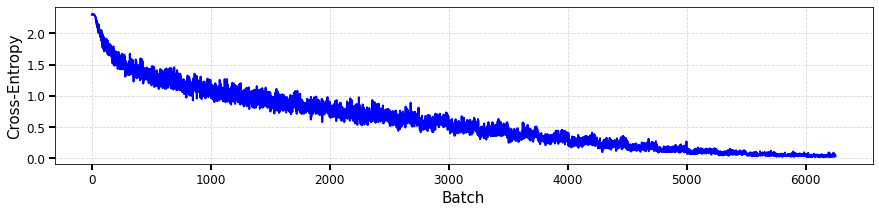

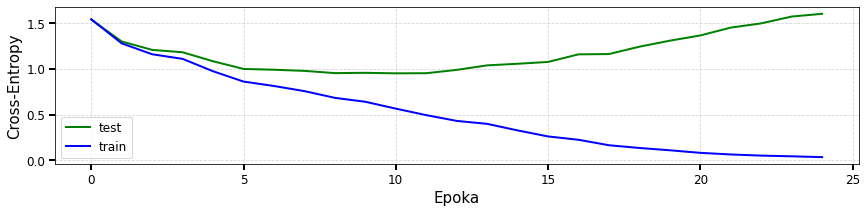

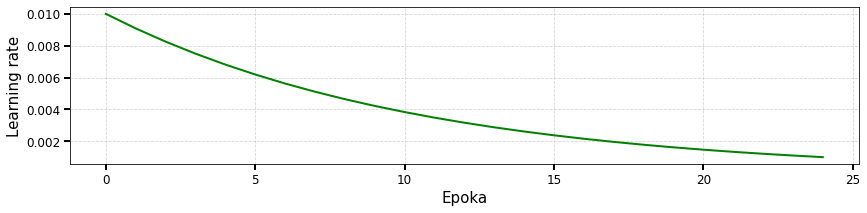

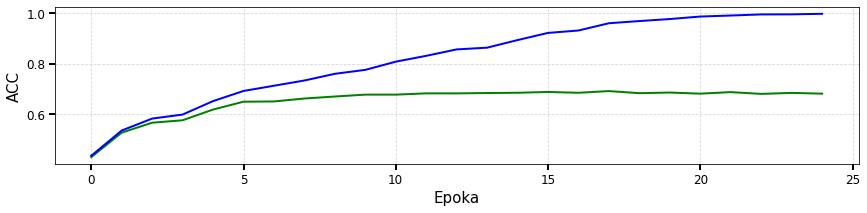

In [17]:
# train loss per batch
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(311)
lns1 = ax.plot(loss_train_perBatch, "b-", linewidth=2, markersize=12, label="train")
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
    labelsize=12,
)

ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.set_ylabel("Cross-Entropy", fontsize=15)
ax.set_xlabel("Batch", fontsize=15)

plt.show()
plt.close()


# train/test loss
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(311)
ax.plot(loss_test, "g-", linewidth=2, markersize=12, label="test")
ax.plot(loss_train, "b-", linewidth=2, markersize=10, label="train")
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
    labelsize=12,
)

ax.legend(loc=0, fontsize=12)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.set_ylabel("Cross-Entropy", fontsize=15)
ax.set_xlabel("Epoka", fontsize=15)

plt.show()
plt.close()


# learning rate
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(311)
lns1 = ax.plot(lrs, "g-", linewidth=2, markersize=12, label="lr")
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
    labelsize=12,
)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.set_ylabel("Learning rate", fontsize=15)
ax.set_xlabel("Epoka", fontsize=15)
plt.tight_layout(pad=0.5)

plt.show()
plt.close()


# acc
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(311)
ax.plot(df.acc_test, "g-", linewidth=2, markersize=12, label="test")
ax.plot(df.acc_train, "b-", linewidth=2, markersize=12, label="train")
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
    labelsize=12,
)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.set_ylabel("ACC", fontsize=15)
ax.set_xlabel("Epoka", fontsize=15)

plt.show()
plt.close()

# Model FC

Poniżej definujemy klasę ,,*Net*'', w której tworzymy sieć neuronową opartą na wartwach fully-connected. 

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 16 * 28 * 28),
            nn.ReLU(),
            nn.Linear(16 * 28 * 28, 32 * 15 * 15),
            nn.ReLU(),
            nn.Linear(32 * 15 * 15, 64 * 13 * 13),
            nn.ReLU(),
            nn.Linear(10816, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        return self.model(x)

Uczenie modelu i jego walidacja.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device.type}")

net = Net()
count_parameters(net)
net.to(device)

criterion = nn.CrossEntropyLoss()

# opt = 'Adam'
opt = "SGD"

num_epochs = 25
lr_start = 0.01
lr_end = 1e-3

if opt == "Adam":
    optimizer = optim.Adam(net.parameters(), lr=lr_start)
else:
    optimizer = optim.SGD(net.parameters(), lr=lr_start, momentum=0.9)


alpha = (lr_end / lr_start) ** (1.0 / (num_epochs - 1))
lmbda = lambda epoch: alpha**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)


lrs = []
loss_train_perBatch = []
loss_train = []
loss_test = []
df = pd.DataFrame(columns=["epoch"])

epoch = 0
epoch_bar = tqdm(range(num_epochs))
for epoch in epoch_bar:

    ############
    # training #
    ############
    net.train()

    pbar = tqdm(trainloader, total=len(trainloader), desc="", leave=False)
    for data in pbar:
        images, targets = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(images)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Loss: {loss.item():.5f}")
        loss_train_perBatch.append(loss.item())

    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

    ##############
    # validation #
    ##############
    net.eval()

    correct, total, num_batch = 0, 0, 0
    correct_pred = {idx: 0 for name, idx in testset.class_to_idx.items()}
    total_pred = {idx: 0 for name, idx in testset.class_to_idx.items()}

    loss_test.append(0.0)
    with torch.no_grad():
        for data in tqdm(testloader, total=len(testloader), desc="Test", leave=False):
            images, targets = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, targets)
            loss_test[-1] += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            for y, pred in zip(targets, predicted):
                y = y.item()
                pred = pred.cpu().item()
                if y == pred:
                    correct_pred[y] += 1
                total_pred[y] += 1
            total += targets.size(0)
            correct += (predicted.cpu() == targets.cpu()).sum().item()
            num_batch += 1

    loss_test[-1] /= num_batch
    logger = {"epoch": epoch + 1, "acc_test": correct / total}

    correct, total, num_batch = 0, 0, 0
    loss_train.append(0)
    with torch.no_grad():
        for data in tqdm(trainloader, total=len(trainloader), desc="", leave=False):
            images, targets = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, targets)
            loss_train[-1] += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted.cpu() == targets.cpu()).sum().item()
            num_batch += 1
    loss_train[-1] /= num_batch
    logger["acc_train"] = correct / total

    for key, val in correct_pred.items():
        logger[f"acc_c{key}"] = val / total_pred[key]

    df = df.append(logger, ignore_index=True)
    epoch_bar.set_description(
        f"lr: {lrs[-1]:.4g}, "
        + ", ".join(
            f"{key}: {logger[key]:.2f}"
            for key, val in logger.items()
            if key in ["acc_test", "acc_train"]
        )
    )

print("Finished training")
# torch.save({'epoch': epoch,
#             'model_state_dict': net.state_dict(),
#             'loss': loss}, f'./cnn_model-cifar10_opt-{opt}.pth')


scores = df.to_dict("list")
scores["loss_train"] = loss_train
scores["loss_test"] = loss_test
scores["loss_train_perBatch"] = loss_train_perBatch
scores["lr"] = lrs

scores_fc = scores

Poniżej przedstawiamy wykresy (funkcji kosztu, dokładności) w czasie uczenia modelu.

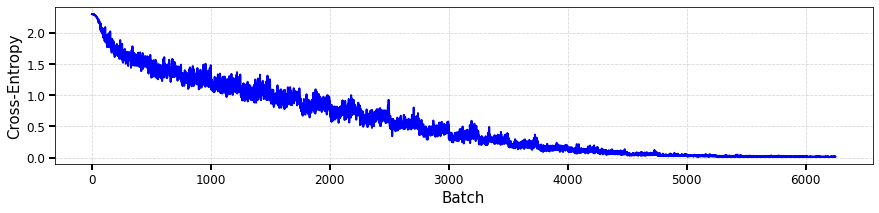

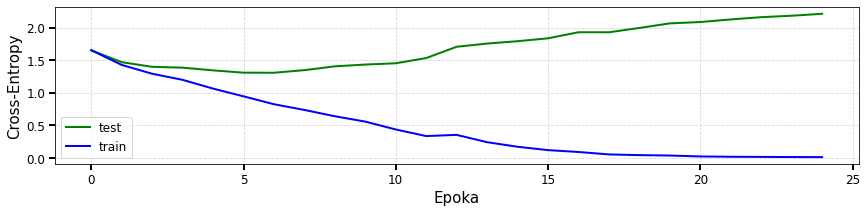

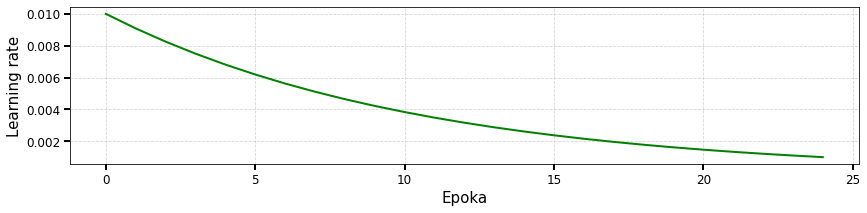

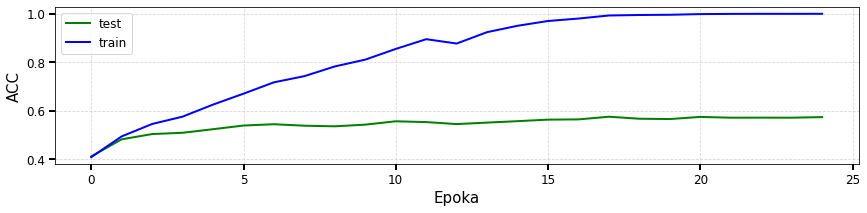

In [21]:
# train loss per batch
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(311)
lns1 = ax.plot(loss_train_perBatch, "b-", linewidth=2, markersize=12, label="train")
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
    labelsize=12,
)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.set_ylabel("Cross-Entropy", fontsize=15)
ax.set_xlabel("Batch", fontsize=15)

plt.show()
plt.close()


# train/test loss
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(311)
ax.plot(loss_test, "g-", linewidth=2, markersize=12, label="test")
ax.plot(loss_train, "b-", linewidth=2, markersize=10, label="train")
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
    labelsize=12,
)

ax.legend(loc=0, fontsize=12)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.set_ylabel("Cross-Entropy", fontsize=15)
ax.set_xlabel("Epoka", fontsize=15)

plt.show()
plt.close()


# learning rate
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(311)
lns1 = ax.plot(lrs, "g-", linewidth=2, markersize=12, label="lr")
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
    labelsize=12,
)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.set_ylabel("Learning rate", fontsize=15)
ax.set_xlabel("Epoka", fontsize=15)

plt.show()
plt.close()


# acc
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(311)
ax.plot(df.acc_test, "g-", linewidth=2, markersize=12, label="test")
ax.plot(df.acc_train, "b-", linewidth=2, markersize=12, label="train")
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
    labelsize=12,
)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)
ax.legend(loc=0, fontsize=12)
ax.set_ylabel("ACC", fontsize=15)
ax.set_xlabel("Epoka", fontsize=15)

plt.show()
plt.close()

# Podsumowanie

Poniżej przedstawiamy na wykresie accuracy (dokładność) modeli CNN i FC.

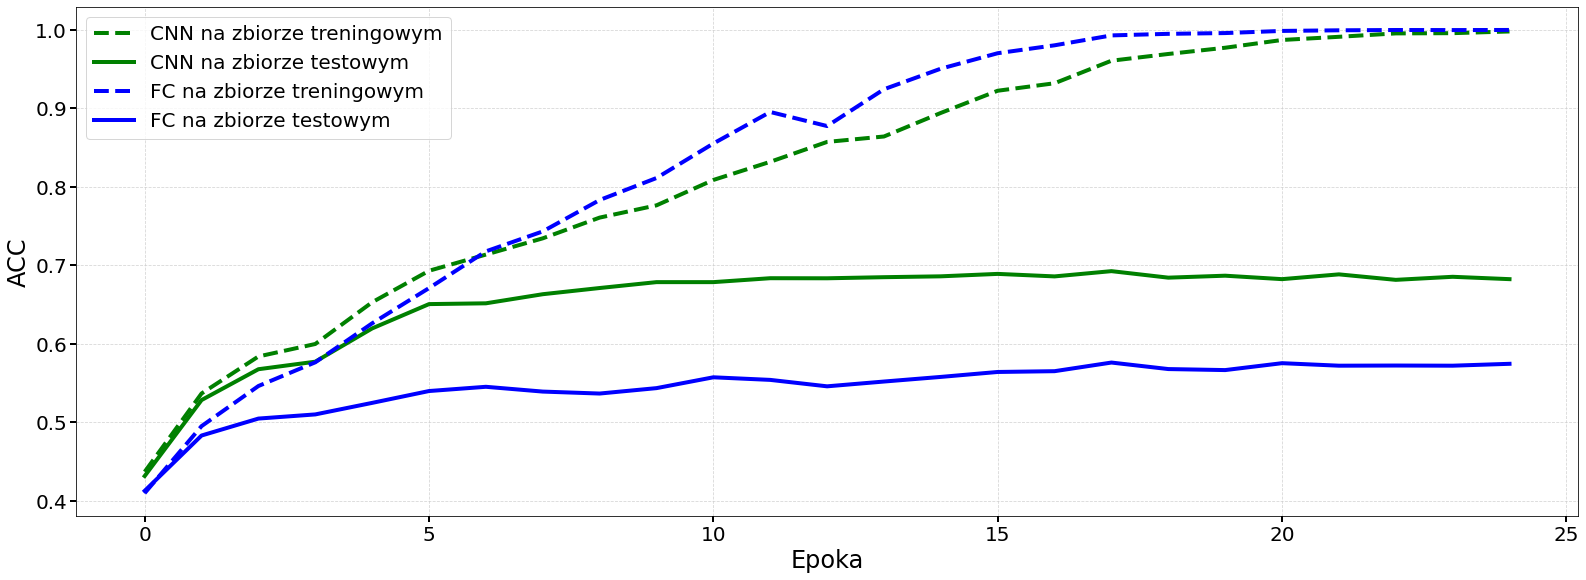

In [2]:
# acc
fig = plt.figure(figsize=(22, 8))
ax = fig.add_subplot(111)
ax.plot(
    scores_cnn["acc_train"],
    "g--",
    linewidth=4,
    markersize=12,
    label="CNN na zbiorze treningowym",
)
ax.plot(
    scores_cnn["acc_test"],
    "g-",
    linewidth=4,
    markersize=12,
    label="CNN na zbiorze testowym",
)
ax.plot(
    scores_fc["acc_train"],
    "b--",
    linewidth=4,
    markersize=12,
    label="FC na zbiorze treningowym",
)
ax.plot(
    scores_fc["acc_test"],
    "b-",
    linewidth=4,
    markersize=12,
    label="FC na zbiorze testowym",
)
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
    labelsize=20,
)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.legend(loc=0, fontsize=20)
ax.set_ylabel("ACC", fontsize=24)
ax.set_xlabel("Epoka", fontsize=24)

plt.show()
plt.close()